## Assignment 1

### 1. Moore's Law

URL for data[http://preshing.com/files/specdata20120207.zip]

check here[https://preshing.com/20120208/a-look-back-at-single-threaded-cpu-performance/] for more information and analysis

1. Extract the date and base speed for a benchmark of your choice. (the dates contained as part of the testID don't tell us about when the hardware was actually designed, so the test could have been run at a much later date using older hardware) -> the date indicating when the hardware was first available can be found from the summaries file to really test Moore's Law. 
2. Plot the data in a semi-log plot
3. Now train a linear model to fit your plot. 
4. How well is Moore's law holding up?

In [31]:
#set up the environment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from datetime import datetime

#import the data
data = pd.read_csv(r'C:\Users\green\Desktop\benchmarks.csv')
summary = pd.read_csv(r'C:\Users\green\Desktop\summaries.csv')
data = summary.merge(data,how='inner',on='testID')
print(data.head())
data = data[data['benchName']=='101.tomcatv']
#instead of using testID as the date as I've used to in the PCW
#use hwAvail (hardware available date) to accurately predict the Moore's Law
data['date']= pd.to_datetime(data.hwAvail, format = "%b-%Y") #it used to be data.testID.str.split('-').str[1]
data.dropna(axis=0, how='all', subset=['date'], inplace=True)

# choose a bench mark to work on: '101.tomcatv'
data.reset_index(drop=True)
#print(data.head)
data = data[['date', 'base_y']]
data = data.rename(columns = {"date":"date","base_y":"base"})

# Datetime to float, so we can plot the graph

data['ordinal'] = data["date"].map(datetime.toordinal)

#make base value in a log so that when it is plotted, it can be a semi-log plot
data['log_base'] = np.log10(data.base.astype(float))
print(data)
#data with 9354 data points for the label '101.tomcatv'

C:\Users\green\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


                 testID tester                             machine  \
0  cpu95-19990104-03254   Dell  Precision WorkStation 610 (450MHz)   
1  cpu95-19990104-03254   Dell  Precision WorkStation 610 (450MHz)   
2  cpu95-19990104-03254   Dell  Precision WorkStation 610 (450MHz)   
3  cpu95-19990104-03254   Dell  Precision WorkStation 610 (450MHz)   
4  cpu95-19990104-03254   Dell  Precision WorkStation 610 (450MHz)   

                       cpu    mhz   hwAvail                            os  \
0  450 MHz Pentium II XEON  450.0  Jan-1999  Microsoft Windows NT 4.0 sp3   
1  450 MHz Pentium II XEON  450.0  Jan-1999  Microsoft Windows NT 4.0 sp3   
2  450 MHz Pentium II XEON  450.0  Jan-1999  Microsoft Windows NT 4.0 sp3   
3  450 MHz Pentium II XEON  450.0  Jan-1999  Microsoft Windows NT 4.0 sp3   
4  450 MHz Pentium II XEON  450.0  Jan-1999  Microsoft Windows NT 4.0 sp3   

                     compiler autoParallel benchType  base_x peak_x  \
0  Intel Fortran Compiler 2.4           No   

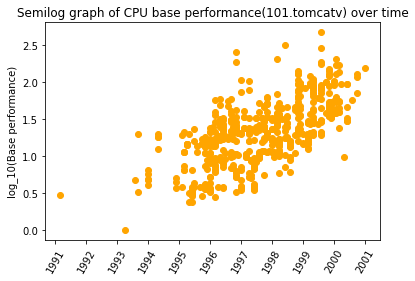

In [32]:
#plot the data in a semi-log plot (Part 2 of the reading)
plt.plot(data['date'], data['log_base'], 'o', color = 'orange')
plt.xticks(rotation = 60)
plt.title('Semilog graph of CPU base performance(101.tomcatv) over time')
plt.ylabel('log_10(Base performance)')
plt.show()

In [33]:
#train the model
import sklearn.metrics as met
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

#data is big and conventionally (according to https://www.researchgate.net/post/Is-there-an-ideal-ratio-between-a-training-set-and-validation-set-Which-trade-off-would-you-suggest)
#it is known to split the data into 20:80 ratio for test and train. 
#split the data
X = data.ordinal.array.reshape(-1,1)
y = data.log_base
#setting random seed as 42 for 'questions of life'
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
prediction = regr.predict(X_test)

#print the evaluations of the model
print("coeffs: ", regr.coef_, ', ',regr.intercept_)
print("MSE : ", met.mean_squared_error(X_test, prediction))
print("median absolute error : ", met.median_absolute_error(y_test, prediction))
print("r2: ", met.r2_score(y_test, prediction))
print("mean absolute error: ", met.mean_absolute_error(y_test, prediction))

coeffs:  [0.00048081] ,  -349.3479680241129
MSE :  531738467988.8542
median absolute error :  0.24452913980294078
r2:  0.4781600908706717
mean absolute error:  0.28536085110649556


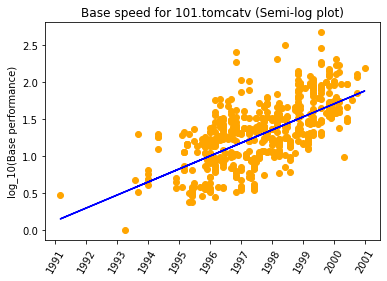

Daily rise in CPU power(log base):  [0.00048081]


In [41]:
#make a regression line (in semi-log plot, regression line should be concave down(curved))
##a linear regression is shown as the blue curve 
#from sklearn.linear_model import LinearRegression 
y_val = regr.coef_*data.ordinal + regr.intercept_
plt.plot(data.date, data['log_base'], 'o', color = 'orange')
plt.plot(data.date, y_val, color = 'blue')
plt.title('Base speed for 101.tomcatv (Semi-log plot)')
plt.ylabel('log_10(Base performance)')
plt.xticks(rotation = 60)
plt.show()
print("Daily rise in CPU power(log base): ", regr.coef_)


In [46]:
print('annual rise in CPU power :', 10**(regr.coef_*365.25))
print('every 2 years, rise in CPU power is : ', 10**(regr.coef_*365.25*2))

annual rise in CPU power : [1.49835492]
every 2 years, rise in CPU power is :  [2.24506745]


According to the regression, we can see that the computer is getting better and better. To prove that Moore's law is holding up, what we do is make a linear line on the semi-log plot, which is actually a exponential plot when y axis becomes non-log again. 

From the coefficient calculated above, it seems that every day there are 0.00048(log base 10) rise, which means in every two years, there is 0.351231705 rise (0.00048081x365.25x2) in log base 10. Thus, 10^(0.00048081*365.25*2) = 2.24506745 times of rise in terms of computing power in every 2 years. 

Moore's law(according to Wikipedia[https://en.wikipedia.org/wiki/Moore%27s_law]) is about semiconductor's density of transistor doubling every 2 years. 

And so far from the result, we can know that the Moore's law is still holding up in some sense even though it may not exactly be 'double' every 2 years. 

### MNIST Digits

No machine learning course would be complete without using the MNIST dataset. This dataset was a hugely influential dataset of handwritten digits (0-9).

http://scikit-learn.org/stable/tutorial/basic/tutorial.html

1. Using Scikit.learn, load the MNIST digits (See here: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits).
2. Plot some of the examples.
3. Choose two digit classes (e.g 7s and 3s) , and train a k-nearest neighbor classifier.
4. Report your error rates on a held out part of the data.
5. (Optional) Test your model on the full dataset (available from http://yann.lecun.com/exdb/mnist/)


(1797, 64)


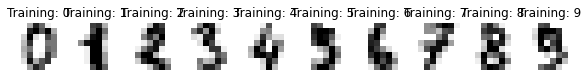

In [55]:
#add more environments for the new task
from sklearn.datasets import load_digits #load the data
import pprint
from IPython.display import display, HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 

digits = load_digits()
#plot some of the examples
print(digits.data.shape)

#show the image of the written number data
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)
    

In [61]:
#pick the data with the two digit classes
#before training the data, split the data into test and training
X = digits.data
y = digits.target
X = X[np.logical_or(y==3,y==7)]
y = y[np.logical_or(y==3,y==7)]
#but why does X = digits.data[np.logical_or(y==3,y==7)] does not work?

trainData,testData,trainLabel,testLabel = train_test_split(X, y, test_size=0.25, random_state=42)

#the good guess for k = sqrt(total number of training data)
model = KNeighborsClassifier(n_neighbors=42) #sqrt(1797) is about 42.4 But, with the given training, 5 works well too. 
model.fit(trainData,trainLabel)
predictions = model.predict(testData)
#print classification report 
print(classification_report(testLabel,predictions)) #has precision and recall
#print(len(predictions))
#print(len(testLabel))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        49

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



In [62]:
print("accuracy score : ", met.accuracy_score(testLabel, predictions))
print("confusion matrix: ")
met.confusion_matrix(testLabel, predictions)

accuracy score :  1.0
confusion matrix: 


array([[42,  0],
       [ 0, 49]], dtype=int64)

Error rate = 1- accuracy. (from up above, it is 5% when k =42, 2% when k = 5)

precision = true positive/spotted positive

recall = true positive/actually positive

f1 score = harmonic mean of the precision and recall = true positive/(true positive + (1/2)(False positive + False negative))

From this, the K-nearest neighbor algorithm has been trained to differenciate 3 and 7 quite well with high accuracy of about 1.00 (when random seed was 123, it was about 0.99). Well, it may be a cause of having such a distinct shape of number, however, other numbers that I've tried with combinations still had high accuracy and f1 scores as well. 

### (Optional) Try test the model on the full dataset. 

In [ ]:
import gzip
